# Impact of State Level Tech High Ed Investment on Tech Output


---




In [116]:
library('dplyr')
library('ggplot2')
library('car')
library('tidyr')
library("stringr")

In [2]:
# Read in the merged df that includes information about higher ed institutions, student populations, and GDP data.
# This merged dataframe comes from the notebook title 'mgt_6203_group_proj'
df <- read.csv("../Data/merged_df.csv")
head(df)

X,unitid,year,state,st_fips,institution_name,CIP11ASSOC,CIP11CERT4,CIP11BACHL,CIP14ASSOC,...,PCIP11,PCIP14,Official.USPS.Code,gdp_description,gdp,institution_name.Name,cip_code,cip_title,level_code,total
1,100654,X1998,Alabama,1,Alabama A & M University,0,0,1,0,...,0.0643,0.0129,AL,"Data processing, hosting, and other information services",161.6,Alabama A & M University,'14.0801',"Civil Engineering, General",Bachelor's degree,7
2,100654,X1998,Alabama,1,Alabama A & M University,0,0,1,0,...,0.0643,0.0129,AL,"Data processing, hosting, and other information services",161.6,Alabama A & M University,'11.0101',"Computer & Information Sciences, General",Master's degree,23
3,100654,X1998,Alabama,1,Alabama A & M University,0,0,1,0,...,0.0643,0.0129,AL,"Data processing, hosting, and other information services",161.6,Alabama A & M University,'11.0101',"Computer & Information Sciences, General",Bachelor's degree,35
4,100654,X1998,Alabama,1,Alabama A & M University,0,0,1,0,...,0.0643,0.0129,AL,"Miscellaneous professional, scientific, and technical services",3235.3,Alabama A & M University,'14.0801',"Civil Engineering, General",Bachelor's degree,7
5,100654,X1998,Alabama,1,Alabama A & M University,0,0,1,0,...,0.0643,0.0129,AL,"Miscellaneous professional, scientific, and technical services",3235.3,Alabama A & M University,'11.0101',"Computer & Information Sciences, General",Master's degree,23
6,100654,X1998,Alabama,1,Alabama A & M University,0,0,1,0,...,0.0643,0.0129,AL,"Miscellaneous professional, scientific, and technical services",3235.3,Alabama A & M University,'11.0101',"Computer & Information Sciences, General",Bachelor's degree,35


In [3]:
# Group both student counts and gdp data by year and state
nstudents <- df %>% 
    group_by(year, state) %>% 
    summarise(nstudents = sum(total))

gdp_info <- df %>% select(year,state,gdp)
gdp <- distinct(gdp_info) %>% 
    group_by(year,state) %>% 
    summarise(gdp = sum(gdp))


# gdp <- df %>% 
#     group_by(year, state) %>% 
#     summarise(gdp = max(gdp))

In [4]:
# Clean the data by filtering to specific years and renaming columns
nstudents <- rename(nstudents, student_year = year)
gdp <- rename(gdp, gdp_year = year)

target_student_year <- 'X2010'
singleNstu <- nstudents %>% filter(student_year == target_student_year)
singleGDP <- gdp %>% filter(gdp_year == 'X2015')

model_data <- left_join(singleNstu, singleGDP, by="state")

In [5]:
# Read in the census data and filter to the most relevant year.
census <- read.csv("../Data/State_census_pop_1990_to_2020.csv")

census <- census %>% select(Name,Pop..2010)
census <- rename(census, state = Name)

head(census)

state,Pop..2010
United States,"308,745,538"
Alabama,"4,779,736"
Alaska,"710,231"
Arizona,"6,392,017"
Arkansas,"2,915,918"
California,"37,253,956"


In [6]:
# Join in the population data and normalize gdp and tech student counts
model_data <- left_join(model_data, census, by = "state")
model_data$Pop..2010 <- as.numeric(gsub(",", "", model_data$Pop..2010))

model_data$gdp_per_capita <- model_data$gdp / model_data$Pop..2010
model_data$nstu_per_capita <- model_data$nstudents / model_data$Pop..2010

Warning message:
“Column `state` joining factors with different levels, coercing to character vector”

## EDA

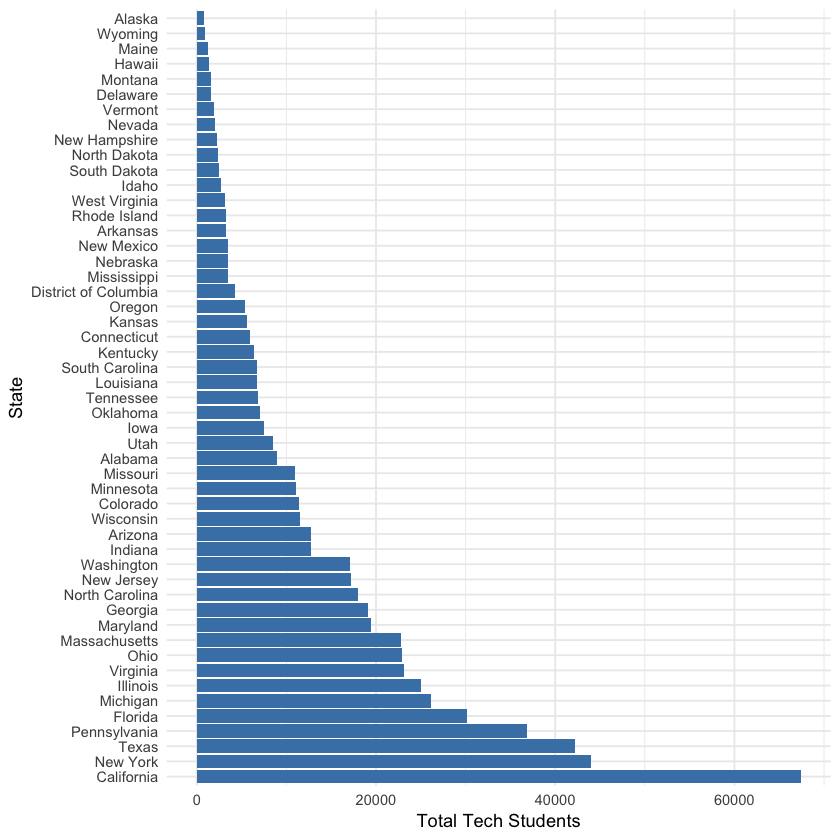

In [7]:
ggplot(model_data, aes(x=reorder(state, -nstudents), y=nstudents)) +
  geom_bar(stat="identity", fill="steelblue") + 
  ylab("Total Tech Students") + xlab("State") + 
  coord_flip() +
  theme_minimal()

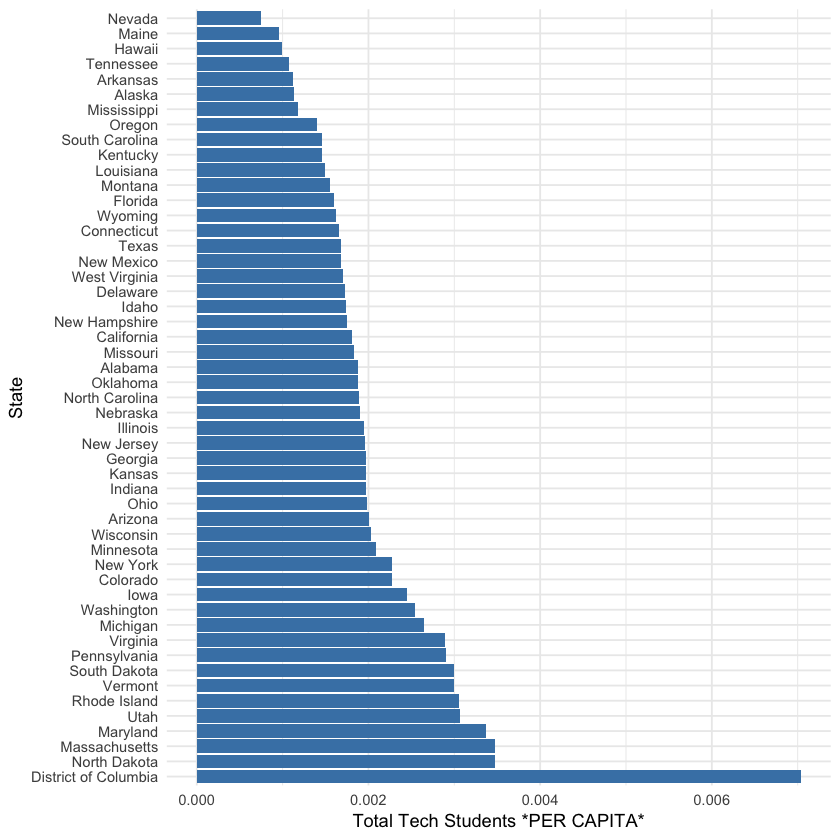

In [8]:
ggplot(model_data, aes(x=reorder(state, -nstu_per_capita), y=nstu_per_capita)) +
  geom_bar(stat="identity", fill="steelblue") + 
  ylab("Total Tech Students *PER CAPITA*") + xlab("State") + 
  coord_flip() +
  theme_minimal()

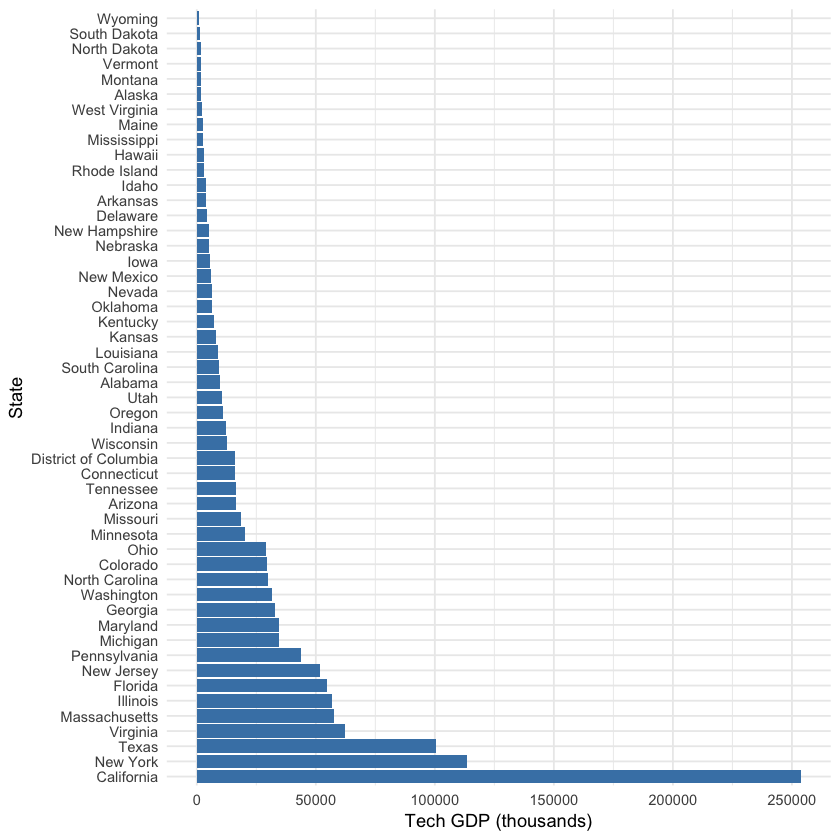

In [9]:
ggplot(model_data, aes(x=reorder(state, -gdp), y=gdp)) +
  geom_bar(stat="identity", fill="steelblue") + 
  ylab("Tech GDP (thousands)") + xlab("State") + 
  coord_flip() +
  theme_minimal()

**Above:** If we look at overall tech GDP we've basically organized the states by total population more or less.

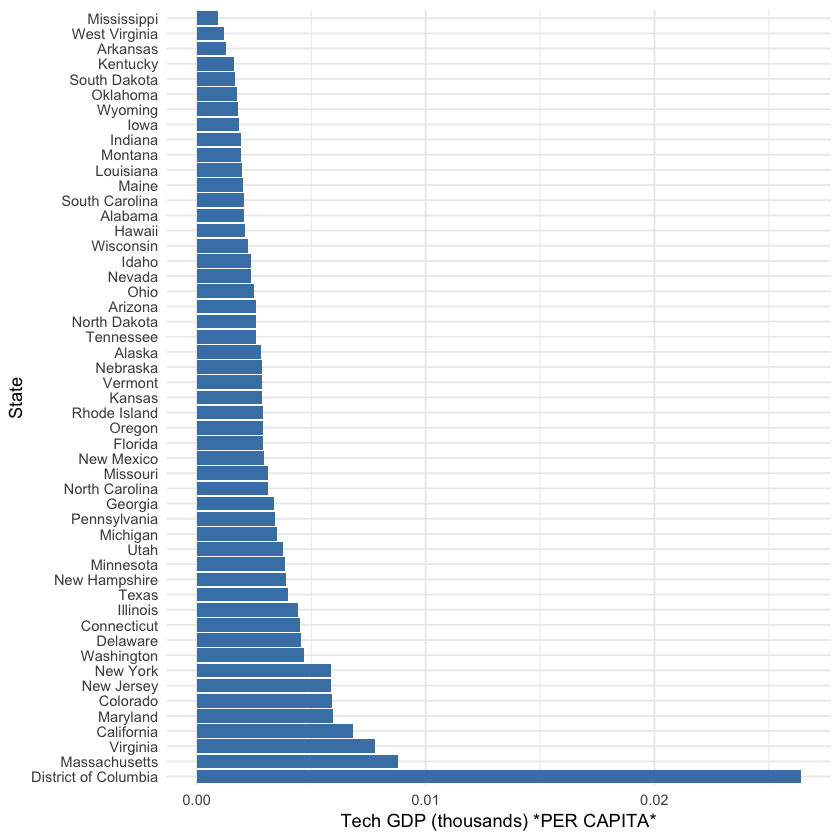

In [10]:
ggplot(model_data, aes(x=reorder(state, -gdp_per_capita), y=gdp_per_capita)) +
  geom_bar(stat="identity", fill="steelblue") + 
  ylab("Tech GDP (thousands) *PER CAPITA*") + xlab("State") + 
  coord_flip() +
  theme_minimal()

**Above:** Here we can see there's much less of trend. It's not necessarily by size, but states with simiilar economies appear next to each other. 

In [11]:
#Scater norm gdp and norm stu population

ERROR: Error in parse(text = x, srcfile = src): <text>:1:8: unexpected symbol
1: Scater norm
           ^


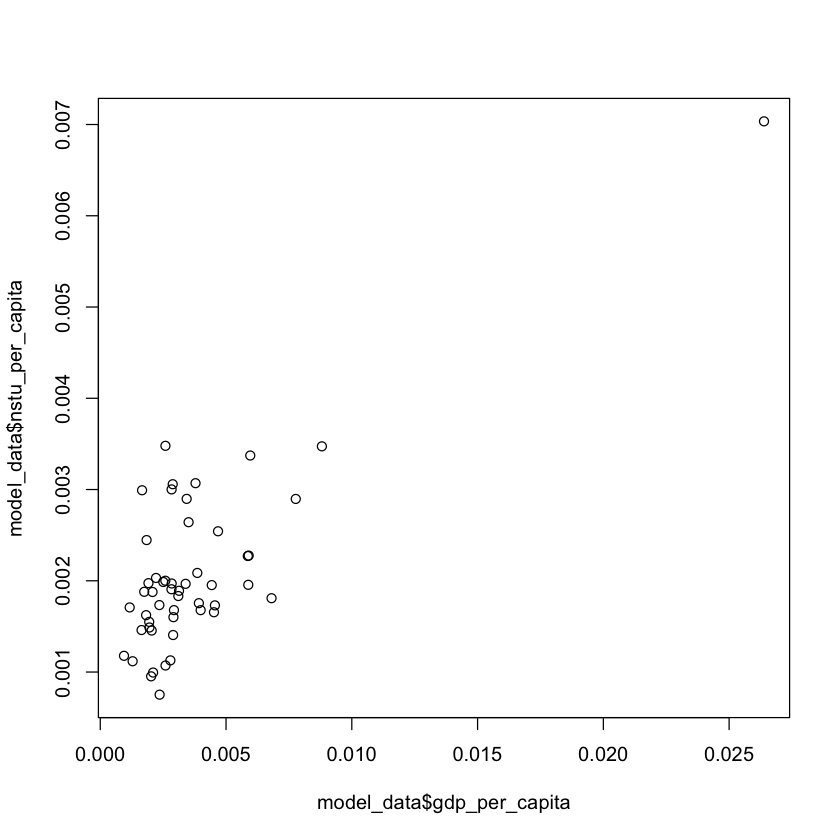

In [24]:
plot(model_data$gdp_per_capita, model_data$nstu_per_capita)

## Modeling

In [12]:
model1 <- lm(gdp ~ nstudents, data = model_data)
summary(model1)


Call:
lm(formula = gdp ~ nstudents, data = model_data)

Residuals:
   Min     1Q Median     3Q    Max 
-50728  -6063   2548   6664  73186 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -9293.2900  3024.7871  -3.072  0.00346 ** 
nstudents       2.8160     0.1679  16.775  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 15880 on 49 degrees of freedom
Multiple R-squared:  0.8517,	Adjusted R-squared:  0.8487 
F-statistic: 281.4 on 1 and 49 DF,  p-value: < 2.2e-16


###### Model 2: Normalized Base Model
---
In model 2 we normalize both the student population and Tech GDP by state population.

In [13]:
model2 <- lm(gdp_per_capita ~ nstu_per_capita, data = model_data)
summary(model2)


Call:
lm(formula = gdp_per_capita ~ nstu_per_capita, data = model_data)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0052835 -0.0011914  0.0000017  0.0015279  0.0079376 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -0.0024732  0.0007497  -3.299  0.00181 ** 
nstu_per_capita  2.9741468  0.3265005   9.109 4.06e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.002246 on 49 degrees of freedom
Multiple R-squared:  0.6287,	Adjusted R-squared:  0.6211 
F-statistic: 82.98 on 1 and 49 DF,  p-value: 4.056e-12


Validating Model Assumptions

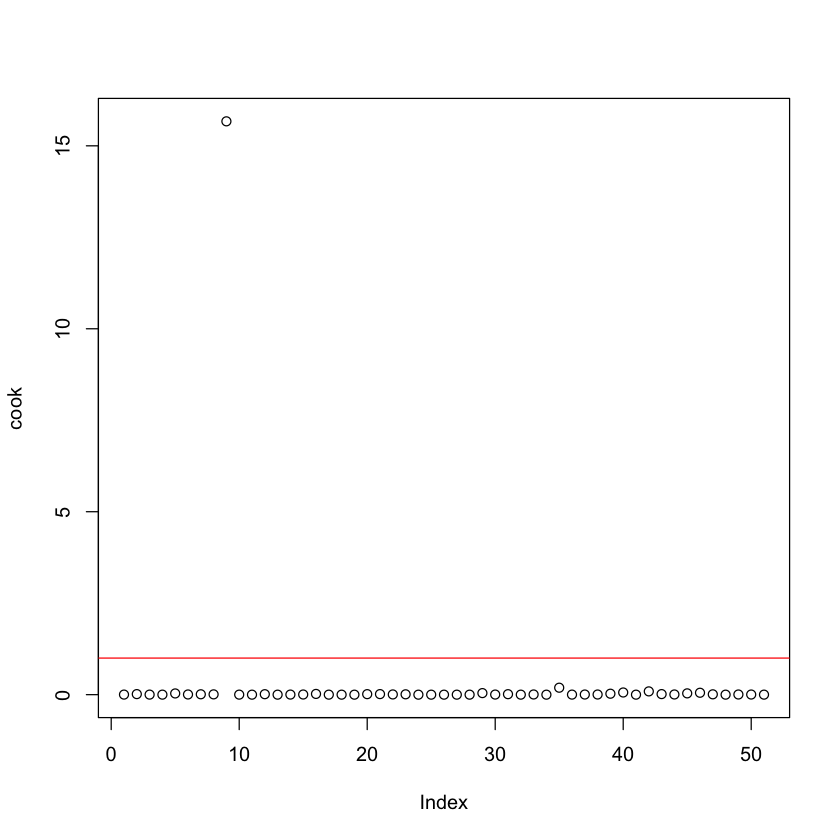

In [14]:
cook=cooks.distance(model2)

plot(cook)
abline(h=1, col="red")

In [15]:
cat("Observation", which(cook>1), "has a cook's distance that is greater than 1")

Observation 9 has a cook's distance that is greater than 1

In [25]:
model_data[9,]

student_year,state,nstudents,gdp_year,gdp,Pop..2010,gdp_per_capita,nstu_per_capita
X2010,District of Columbia,4233,X2015,15877.6,601723,0.02638689,0.007034798


**ANALYSIS:** DC is a clear outlier. We're going to remove the point and rerun the model.

In [27]:
model_data2 <- model_data[-9,]

In [17]:
resids2 = rstandard(model2)

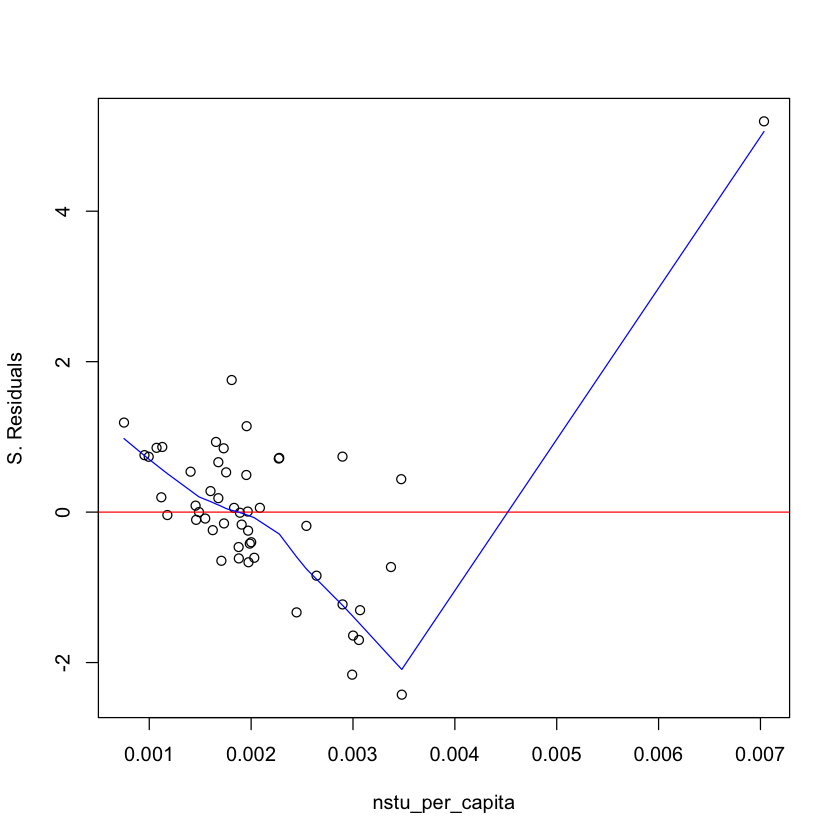

In [18]:
col_name <- names(model_data)[8] # nstu_per_capita
y_data <- as.vector(model_data[,col_name])
plot(model_data$nstu_per_capita, resids2, xlab= col_name, ylab = "S. Residuals")
abline(h=0, col="red")
lines(lowess(model_data$nstu_per_capita, resids2), col='blue')

[1]  9 35

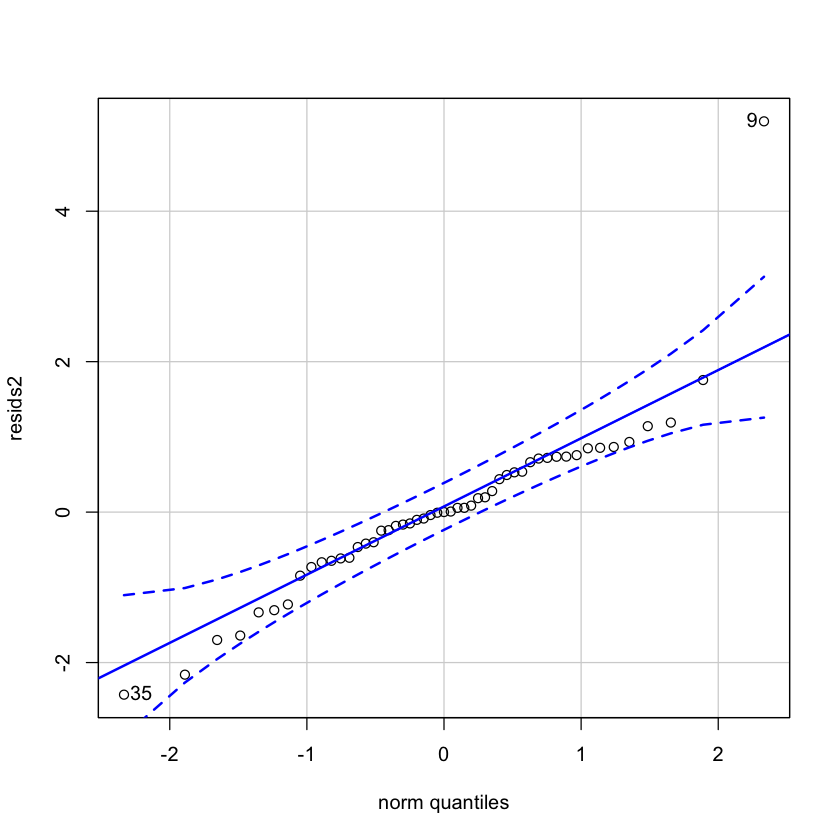

In [21]:
qqPlot(resids2)

###### Model 3: Normalized Base Model No Outlier
---
In model 3 we normalize both the student population and Tech GDP by state population AND removed DC as an outliner.

In [30]:
model3 <- lm(gdp_per_capita ~ nstu_per_capita, data = model_data2)
summary(model3)


Call:
lm(formula = gdp_per_capita ~ nstu_per_capita, data = model_data2)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0027984 -0.0009990 -0.0001909  0.0006999  0.0037822 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     0.0009296  0.0006742   1.379 0.174343    
nstu_per_capita 1.1800243  0.3218792   3.666 0.000615 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.001521 on 48 degrees of freedom
Multiple R-squared:  0.2187,	Adjusted R-squared:  0.2025 
F-statistic: 13.44 on 1 and 48 DF,  p-value: 0.0006153


In [32]:
resids3 = rstandard(model3)

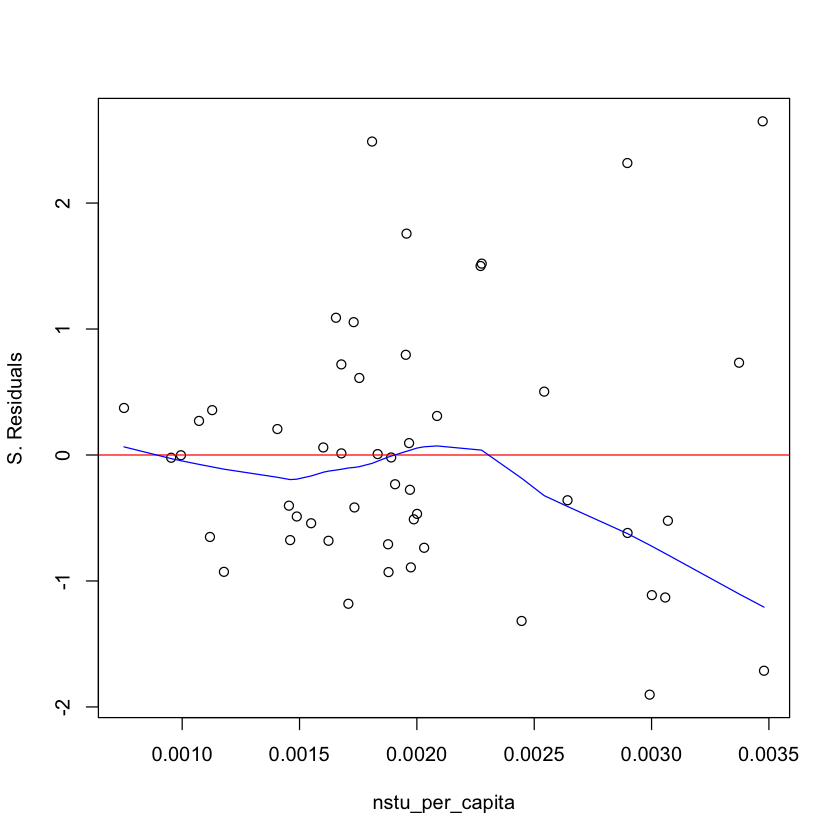

In [33]:
col_name <- names(model_data2)[8] # nstu_per_capita
y_data <- as.vector(model_data2[,col_name])
plot(model_data2$nstu_per_capita, resids3, xlab= col_name, ylab = "S. Residuals")
abline(h=0, col="red")
lines(lowess(model_data2$nstu_per_capita, resids3), col='blue')

[1] 21  5

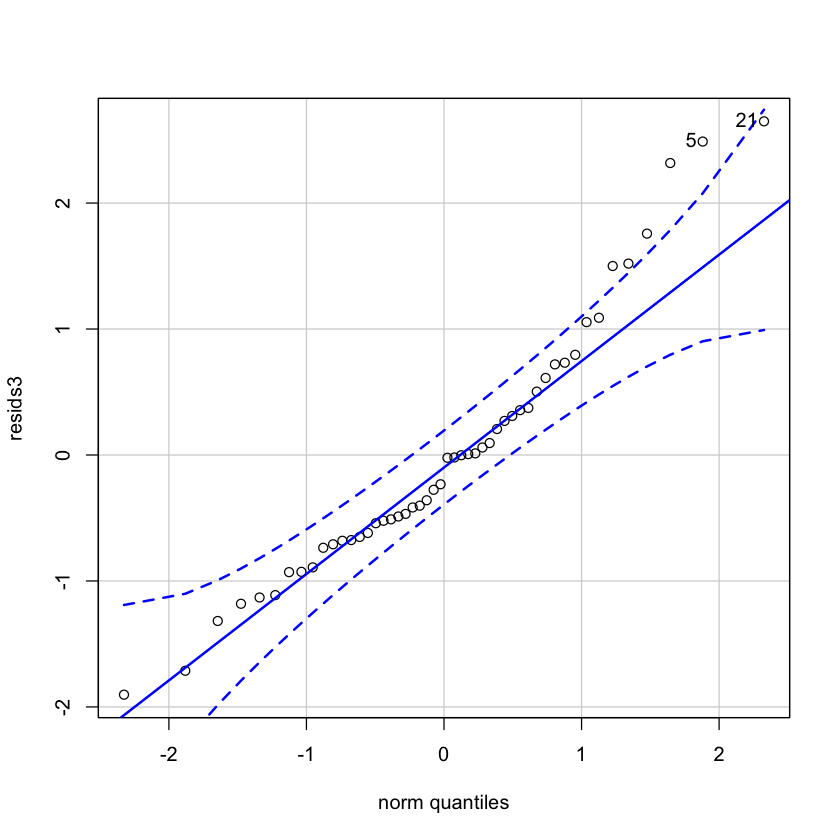

In [34]:
qqPlot(resids3)

###### Model 3: Focus on Public Universities 
---
Here we'll explore the impact of institutional control on outcomes. Control falls into three categories; non-public,private for-profit, and private non-profit 

1	Public  
2	Private nonprofit  
3	Private for-profit  

In [22]:
scData <- read.csv('../Data/scorecard_select_data_10_11.csv')
head(scData)

X,unitid,year,state,st_fips,institution_name,CIP11ASSOC,CIP11CERT4,CIP11BACHL,CIP14ASSOC,...,PCIP11,PCIP14,Official.USPS.Code,gdp_description,gdp,institution_name.Name,cip_code,cip_title,level_code,total
1,100654,X1998,Alabama,1,Alabama A & M University,0,0,1,0,...,0.0643,0.0129,AL,"Data processing, hosting, and other information services",161.6,Alabama A & M University,'14.0801',"Civil Engineering, General",Bachelor's degree,7
2,100654,X1998,Alabama,1,Alabama A & M University,0,0,1,0,...,0.0643,0.0129,AL,"Data processing, hosting, and other information services",161.6,Alabama A & M University,'11.0101',"Computer & Information Sciences, General",Master's degree,23
3,100654,X1998,Alabama,1,Alabama A & M University,0,0,1,0,...,0.0643,0.0129,AL,"Data processing, hosting, and other information services",161.6,Alabama A & M University,'11.0101',"Computer & Information Sciences, General",Bachelor's degree,35
4,100654,X1998,Alabama,1,Alabama A & M University,0,0,1,0,...,0.0643,0.0129,AL,"Miscellaneous professional, scientific, and technical services",3235.3,Alabama A & M University,'14.0801',"Civil Engineering, General",Bachelor's degree,7
5,100654,X1998,Alabama,1,Alabama A & M University,0,0,1,0,...,0.0643,0.0129,AL,"Miscellaneous professional, scientific, and technical services",3235.3,Alabama A & M University,'11.0101',"Computer & Information Sciences, General",Master's degree,23
6,100654,X1998,Alabama,1,Alabama A & M University,0,0,1,0,...,0.0643,0.0129,AL,"Miscellaneous professional, scientific, and technical services",3235.3,Alabama A & M University,'11.0101',"Computer & Information Sciences, General",Bachelor's degree,35


In [35]:
oneYearDF<- df %>% filter(year == target_student_year)
oneYearDF <- rename(oneYearDF, UNITID = unitid)

control_df <- left_join(oneYearDF,scData, by='UNITID')

nstudents_c <- control_df %>% 
    group_by(state, CONTROL) %>% 
    summarise(nstudents = sum(total))

nstudents_c$CONTROL <- factor(nstudents_c$CONTROL, labels=c('Public','Private_NonProfit','Private_ForProfit'))

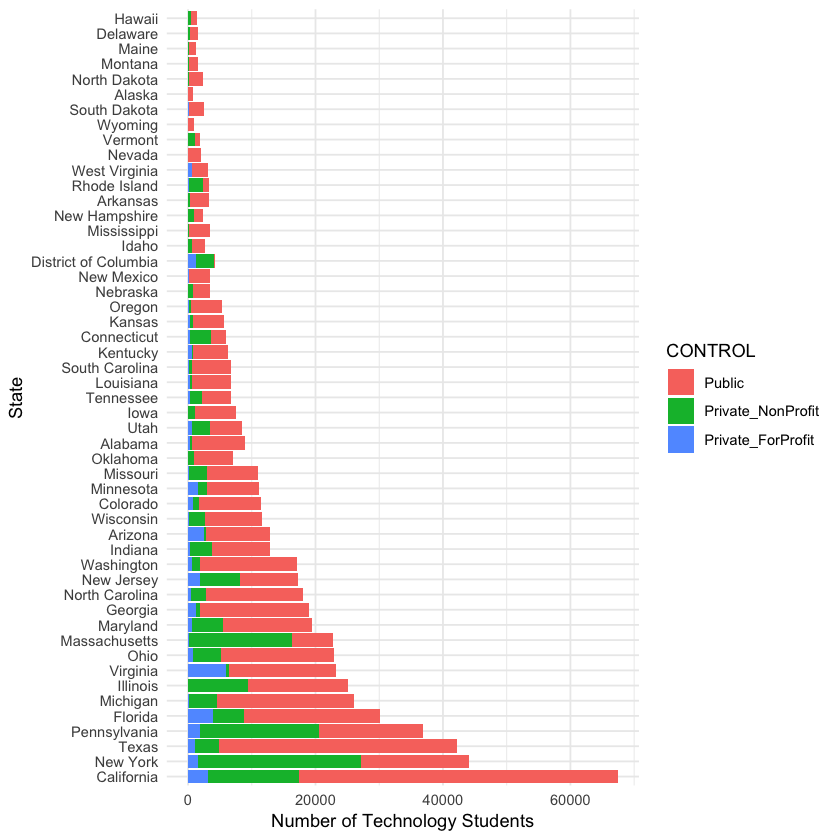

In [52]:
ggplot(nstudents_c, aes(fill=CONTROL, y=nstudents, x=reorder(state, -nstudents))) + 
    geom_bar(position="stack", stat="identity") + coord_flip() +
  theme_minimal() + xlab('State') + ylab('Number of Technology Students')

In [55]:
model_data_c <- left_join(nstudents_c, singleGDP, by="state")

In [56]:
model_data_c <- left_join(model_data_c, census, by = "state")
model_data_c$Pop..2010 <- as.numeric(gsub(",", "", model_data_c$Pop..2010))

model_data_c$gdp_per_capita <- model_data_c$gdp / model_data_c$Pop..2010
model_data_c$nstu_per_capita <- model_data_c$nstudents / model_data_c$Pop..2010

Warning message:
“Column `state` joining factors with different levels, coercing to character vector”

In [61]:
model4 <- lm(gdp_per_capita ~ nstu_per_capita + CONTROL, data = model_data_c)
summary(model4)


Call:
lm(formula = gdp_per_capita ~ nstu_per_capita + CONTROL, data = model_data_c)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0061017 -0.0014795 -0.0005521  0.0006158  0.0257501 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)              -0.0001076  0.0008405  -0.128 0.898361    
nstu_per_capita           2.6660659  0.4794596   5.561 1.37e-07 ***
CONTROLPrivate_NonProfit  0.0024355  0.0008106   3.004 0.003168 ** 
CONTROLPrivate_ForProfit  0.0037218  0.0009465   3.932 0.000134 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.003434 on 136 degrees of freedom
Multiple R-squared:  0.1862,	Adjusted R-squared:  0.1682 
F-statistic: 10.37 on 3 and 136 DF,  p-value: 3.429e-06


In [64]:
limited_model_data_c <- select(model_data_c,state,CONTROL, nstu_per_capita)

reshaped_model_data_c <- spread(limited_model_data_c, CONTROL, nstu_per_capita)
gdp_per <- select(model_data,state,gdp_per_capita, gdp)

reshaped_model_data_c <- left_join(reshaped_model_data_c, gdp_per, by = 'state')
reshaped_model_data_c <- reshaped_model_data_c[-9,]

In [95]:
model5 <- lm(gdp_per_capita ~ Public + Private_NonProfit + Private_ForProfit, data = reshaped_model_data_c)
summary(model5)


Call:
lm(formula = gdp_per_capita ~ Public + Private_NonProfit + Private_ForProfit, 
    data = reshaped_model_data_c)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0034209 -0.0009862 -0.0001262  0.0011019  0.0036631 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.0014571  0.0008433   1.728 0.092843 .  
Public            0.4298059  0.4650202   0.924 0.361673    
Private_NonProfit 1.8945265  0.4736736   4.000 0.000313 ***
Private_ForProfit 4.5681554  1.8423173   2.480 0.018116 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.001524 on 35 degrees of freedom
  (11 observations deleted due to missingness)
Multiple R-squared:  0.3738,	Adjusted R-squared:  0.3201 
F-statistic: 6.965 on 3 and 35 DF,  p-value: 0.0008515


In [96]:
resids_c =rstandard(model5)

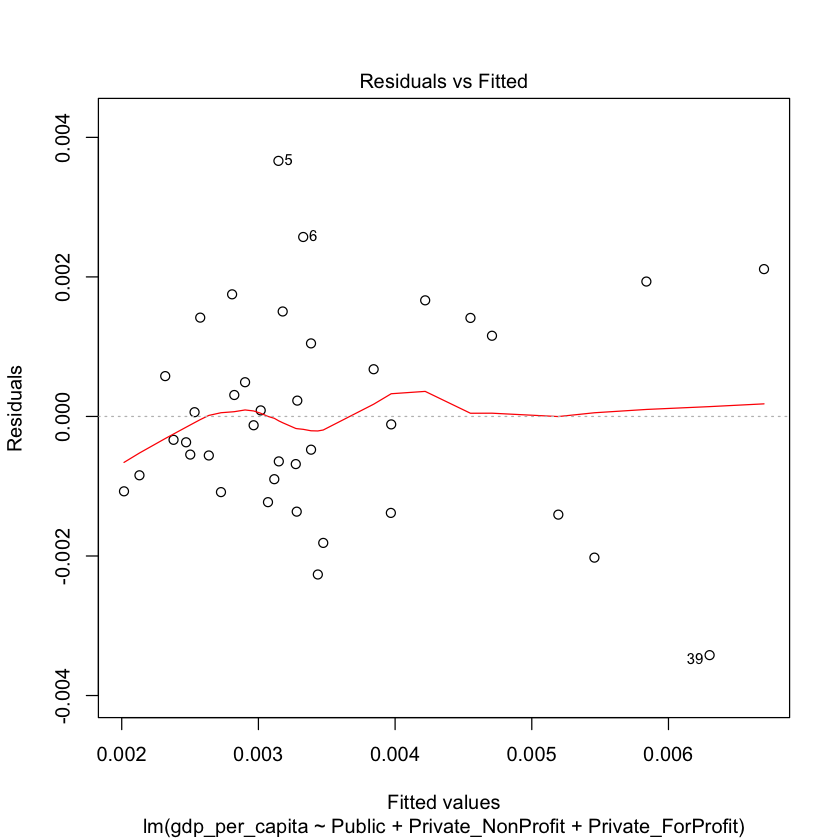

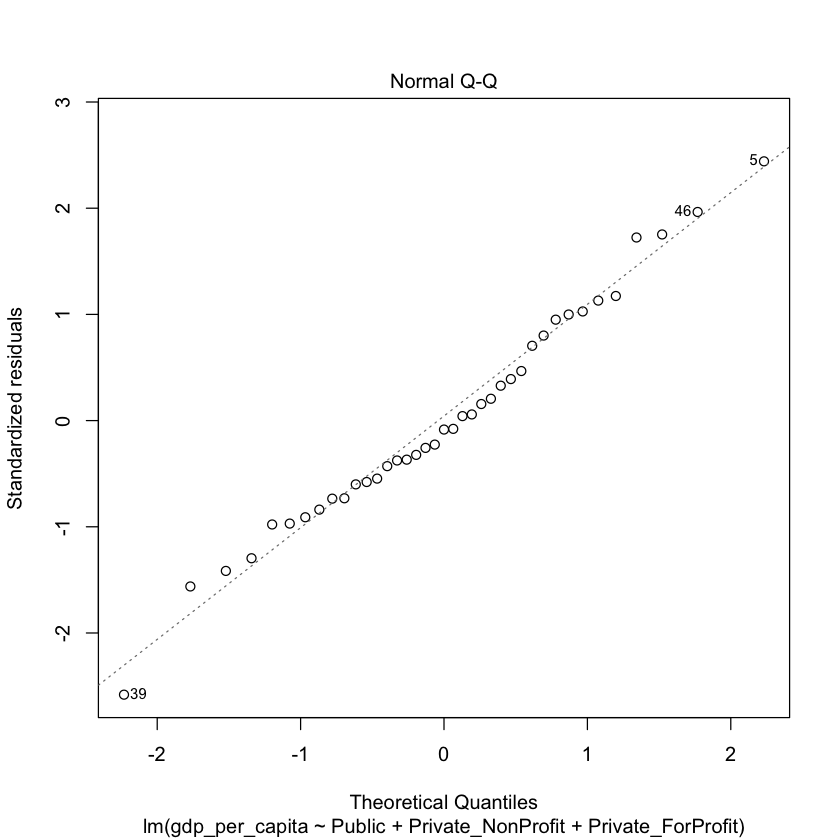

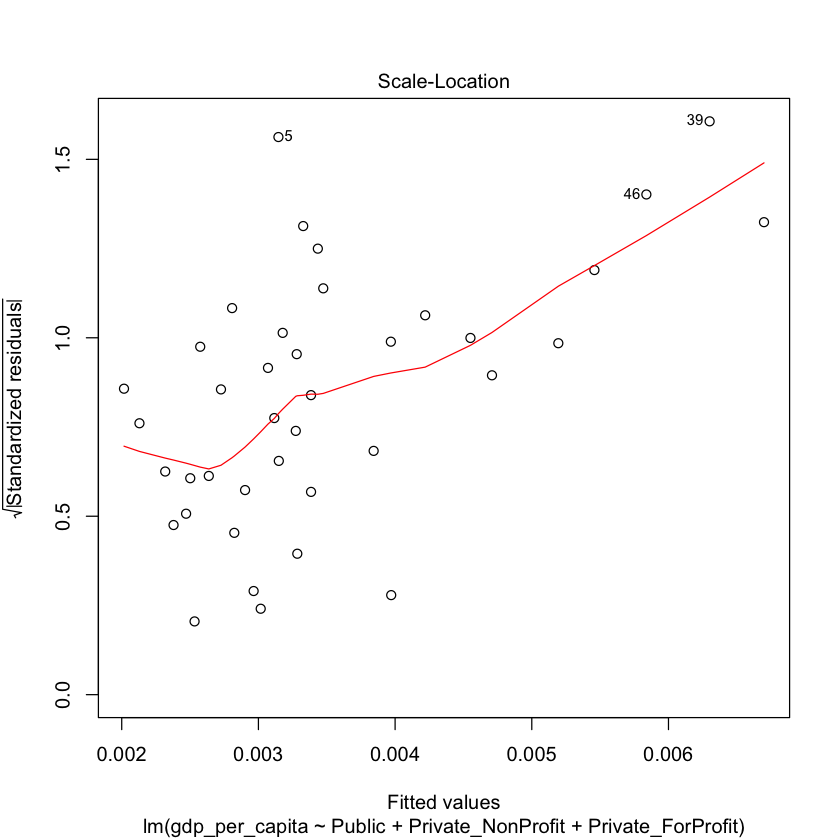

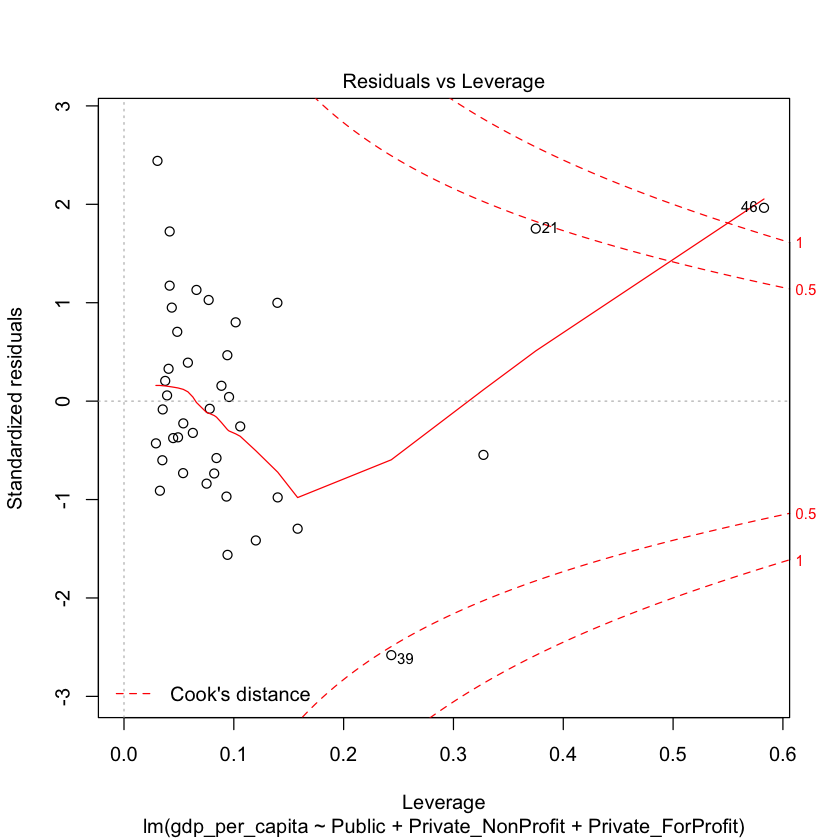

In [107]:
plot(model5)

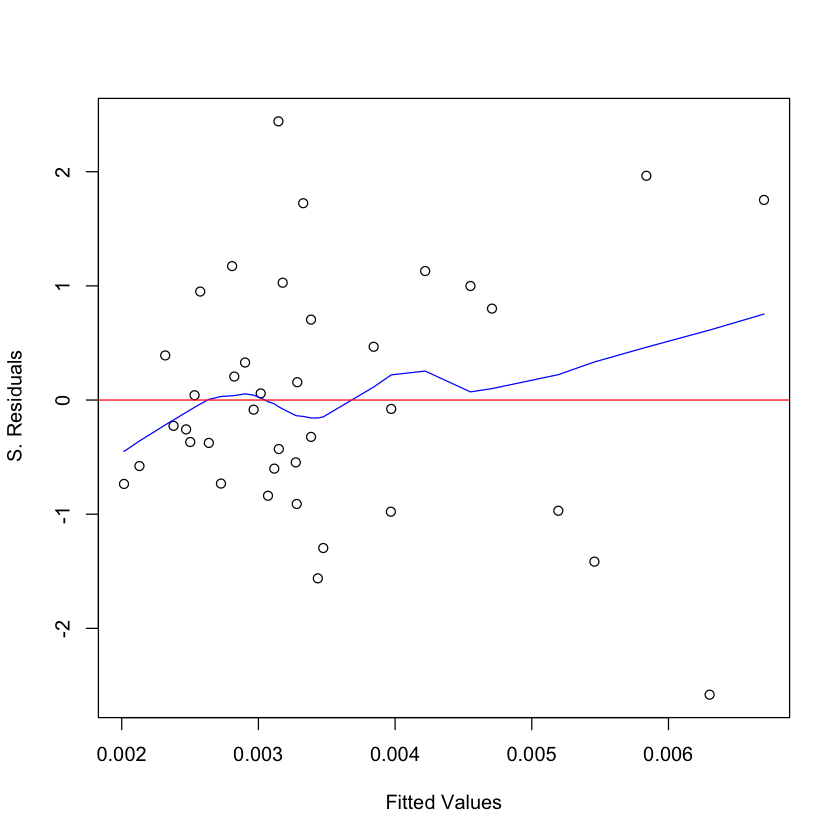

In [105]:
plot(model5$fitted.values, resids_c, xlab="Fitted Values", ylab=" S. Residuals")
lines(lowess(model5$fitted.values, resids_c), col='blue')
abline(h=0, col="red")

39  5 
30  4

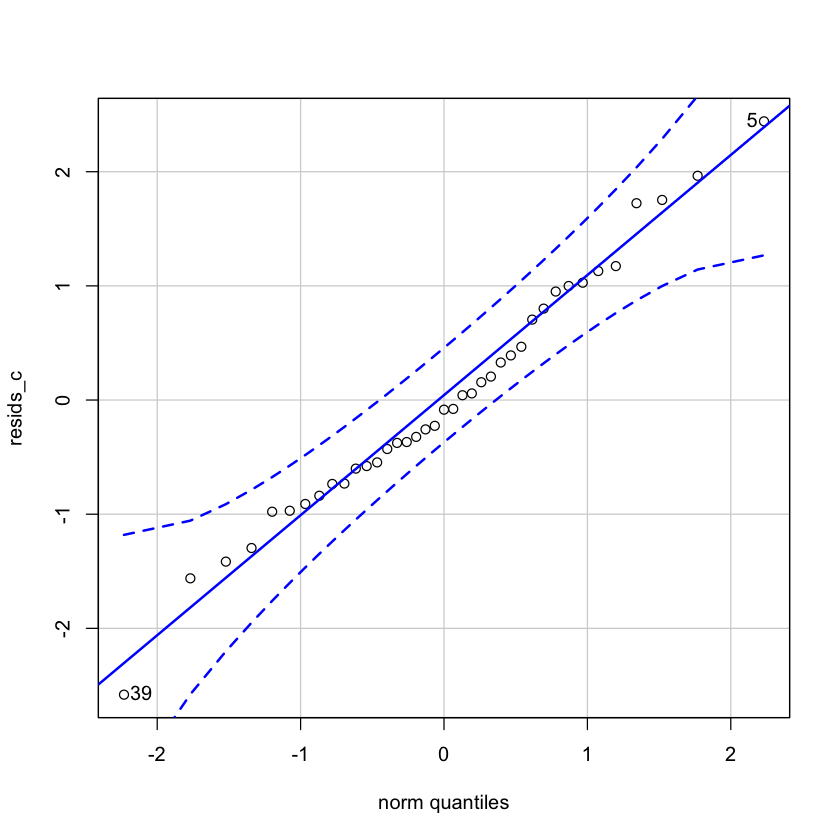

In [104]:
qqPlot(resids_c)

###### Model 6: Focus on Impact of Graduate Students
---
Here we explore whether graduate students have a differentied impact from undergrad students. 

In [230]:
nstudents_l <- df %>% 
    group_by(year, state, level_code) %>% 
    summarise(nstudents = sum(total))

In [231]:
nstudents_l$level_code <- str_replace_all(nstudents_l$level_code, "Associate's degree", "Less Than Bachelors")
nstudents_l$level_code <- str_replace_all(nstudents_l$level_code, "Award of at least 1 but less than 2 academic years", "Less Than Bachelors")
nstudents_l$level_code <- str_replace_all(nstudents_l$level_code, "Award of at least 2 but less than 4 academic years", "Less Than Bachelors")
nstudents_l$level_code <- str_replace_all(nstudents_l$level_code, "Award of less than 1 academic year", "Less Than Bachelors")
nstudents_l$level_code <- str_replace_all(nstudents_l$level_code, "First-professional degree", "Less Than Bachelors")
nstudents_l$level_code <- str_replace_all(nstudents_l$level_code, "Post-master's certificate", "Less Than Bachelors")
nstudents_l$level_code <- str_replace_all(nstudents_l$level_code, "Postbaccalaureate certificate", "Less Than Bachelors")
nstudents_l$level_code <- str_replace_all(nstudents_l$level_code, "Certificates of at least 1 but less than 2 years", "Less Than Bachelors")
nstudents_l$level_code <- str_replace_all(nstudents_l$level_code, "Certificates of less than 12 weeks ", "Less Than Bachelors")
nstudents_l$level_code <- str_replace_all(nstudents_l$level_code, "Certificates of at least 12 weeks but less than 1 year", "Less Than Bachelors")
nstudents_l$level_code <- str_replace_all(nstudents_l$level_code, "Certificates of less than 1 year", "Less Than Bachelors")
nstudents_l$level_code <- str_replace_all(nstudents_l$level_code, "Certificates of at least 2 but less than 4 years", "Less Than Bachelors")
nstudents_l$level_code <- str_replace_all(nstudents_l$level_code, "First-professional certificate", "Less Than Bachelors")
nstudents_l$level_code <- str_replace_all(nstudents_l$level_code, "Certificates of less than 12 weeks", "Less Than Bachelors")



nstudents_l$level_code <- str_replace_all(nstudents_l$level_code, "(?:Doctor's degree - professional practice \\(new degree classification\\))", "Masters or PhD")
nstudents_l$level_code <- str_replace_all(nstudents_l$level_code, "(?:Doctor's degree - other \\(new degree classification\\))", "Masters or PhD")
nstudents_l$level_code <- str_replace_all(nstudents_l$level_code, "(?:Doctor's degree - research/scholarship \\(new degree classification\\))", "Masters or PhD")
nstudents_l$level_code <- str_replace_all(nstudents_l$level_code, "(?:Doctor's degree \\(old degree classification\\))", "Masters or PhD")
nstudents_l$level_code <- str_replace_all(nstudents_l$level_code, "Doctor's degree - research/scholarship", "Masters or PhD")
nstudents_l$level_code <- str_replace_all(nstudents_l$level_code, "Doctor's degree - professional practice", "Masters or PhD")
nstudents_l$level_code <- str_replace_all(nstudents_l$level_code, "Doctor's degree - other", "Masters or PhD")
nstudents_l$level_code <- str_replace_all(nstudents_l$level_code, "Doctor's degree", "Masters or PhD")
nstudents_l$level_code <- str_replace_all(nstudents_l$level_code, "Master's degree", "Masters or PhD")



In [235]:
nstudents_l <- nstudents_l %>% group_by(year,state,level_code) %>% summarise(nstudents = sum(nstudents))

In [244]:
singleNstu_l <- nstudents_l %>% filter(year == target_student_year)


In [245]:
head(singleNstu_l)

year,state,level_code,nstudents
X2010,Alabama,Bachelor's degree,5730
X2010,Alabama,Less Than Bachelors,915
X2010,Alabama,Masters or PhD,2328
X2010,Alaska,Bachelor's degree,489
X2010,Alaska,Less Than Bachelors,129
X2010,Alaska,Masters or PhD,183


In [259]:
model_data_l <- left_join(singleNstu_l, singleGDP, by="state")

In [260]:
model_data_l <- left_join(model_data_l, census, by = "state")
model_data_l$Pop..2010 <- as.numeric(gsub(",", "", model_data_l$Pop..2010))

model_data_l$gdp_per_capita <- model_data_l$gdp / model_data_l$Pop..2010
model_data_l$nstu_per_capita <- model_data_l$nstudents / model_data_l$Pop..2010

Warning message:
“Column `state` joining factors with different levels, coercing to character vector”

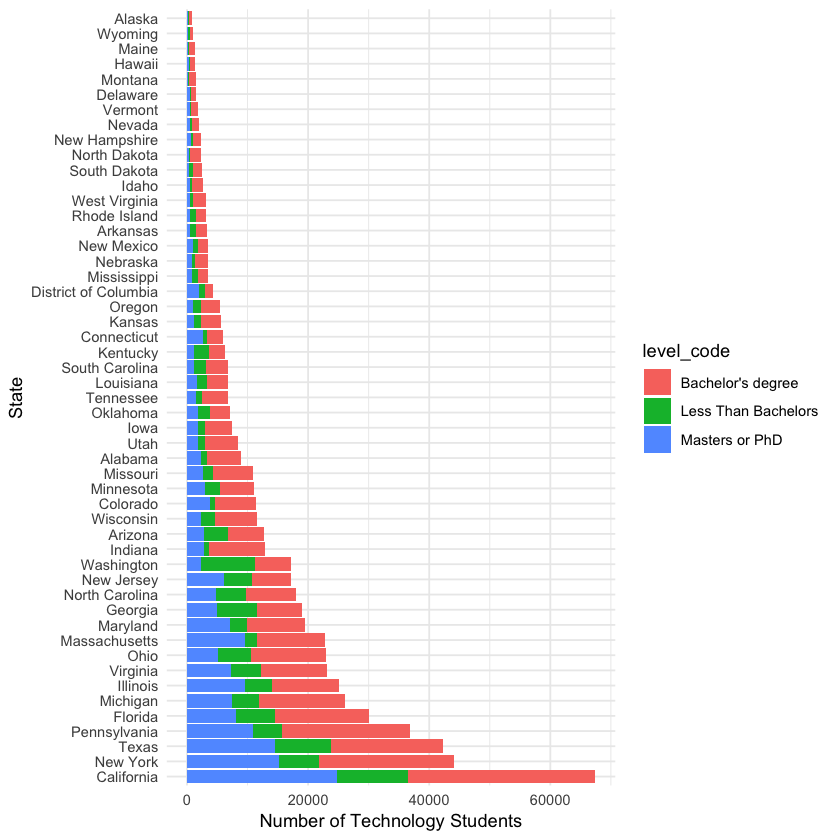

In [261]:
ggplot(model_data_l, aes(fill=level_code, y=nstudents, x=reorder(state, -nstudents))) + 
    geom_bar(position="stack", stat="identity") + coord_flip() +
  theme_minimal() + xlab('State') + ylab('Number of Technology Students')

In [262]:
head(model_data_l)

year,state,level_code,nstudents,gdp_year,gdp,Pop..2010,gdp_per_capita,nstu_per_capita
X2010,Alabama,Bachelor's degree,5730,X2015,9930.7,4779736,0.002077667,0.0011988110
X2010,Alabama,Less Than Bachelors,915,X2015,9930.7,4779736,0.002077667,0.0001914332
X2010,Alabama,Masters or PhD,2328,X2015,9930.7,4779736,0.002077667,0.0004870562
X2010,Alaska,Bachelor's degree,489,X2015,1979.9,710231,0.002787685,0.0006885084
X2010,Alaska,Less Than Bachelors,129,X2015,1979.9,710231,0.002787685,0.0001816310
X2010,Alaska,Masters or PhD,183,X2015,1979.9,710231,0.002787685,0.0002576626


In [265]:
limited_model_data_l <- select(model_data_l,state,level_code, nstu_per_capita)

reshaped_model_data_l <- spread(limited_model_data_l, level_code, nstu_per_capita)
gdp_per <- select(model_data,state,gdp_per_capita, gdp)

reshaped_model_data_l <- left_join(reshaped_model_data_l, gdp_per, by = 'state')
reshaped_model_data_l <- reshaped_model_data_l[-9,]

Adding missing grouping variables: `year`
Adding missing grouping variables: `student_year`


In [270]:
names(reshaped_model_data_l)[3] <- 'Bachelors_Degree'
names(reshaped_model_data_l)[4] <- 'Less_Than_Bachelors'
names(reshaped_model_data_l)[5] <- 'Masters_PhD'

In [271]:
head(reshaped_model_data_l)

year,state,Bachelors_Degree,Less_Than_Bachelors,Masters_PhD,student_year,gdp_per_capita,gdp
X2010,Alabama,0.0011988110,0.0001914332,0.0004870562,X2010,0.002077667,9930.7
X2010,Alaska,0.0006885084,0.0001816310,0.0002576626,X2010,0.002787685,1979.9
X2010,Arizona,0.0009428949,0.0006087280,0.0004491540,X2010,0.002586476,16532.8
X2010,Arkansas,0.0006234743,0.0003508329,0.0001440370,X2010,0.001286284,3750.7
X2010,California,0.0008300058,0.0003158322,0.0006632316,X2010,0.006809457,253679.2
X2010,Colorado,0.0013570758,0.0001765690,0.0007426634,X2010,0.005899671,29670.6


In [272]:
model6 <- lm(gdp_per_capita ~  Bachelors_Degree + Less_Than_Bachelors + Masters_PhD, data = reshaped_model_data_l)
summary(model6)


Call:
lm(formula = gdp_per_capita ~ Bachelors_Degree + Less_Than_Bachelors + 
    Masters_PhD, data = reshaped_model_data_l)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0016844 -0.0006013 -0.0001369  0.0005583  0.0023443 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          0.0011923  0.0004386   2.718  0.00922 ** 
Bachelors_Degree    -0.9326216  0.3649594  -2.555  0.01398 *  
Less_Than_Bachelors  0.2654861  0.6349123   0.418  0.67779    
Masters_PhD          5.9753406  0.6095300   9.803 7.63e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0009788 on 46 degrees of freedom
Multiple R-squared:  0.6901,	Adjusted R-squared:  0.6699 
F-statistic: 34.15 on 3 and 46 DF,  p-value: 9.139e-12


In [273]:
resids_l =rstandard(model6)

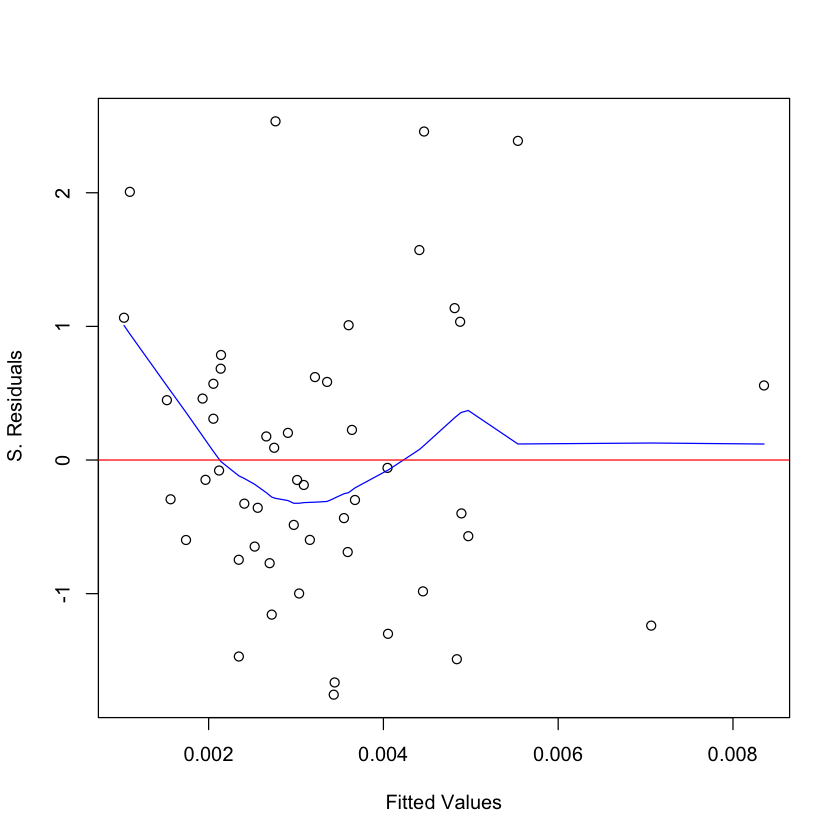

In [274]:
plot(model6$fitted.values, resids_l, xlab="Fitted Values", ylab=" S. Residuals")
lines(lowess(model6$fitted.values, resids_l), col='blue')
abline(h=0, col="red")

[1] 47  5

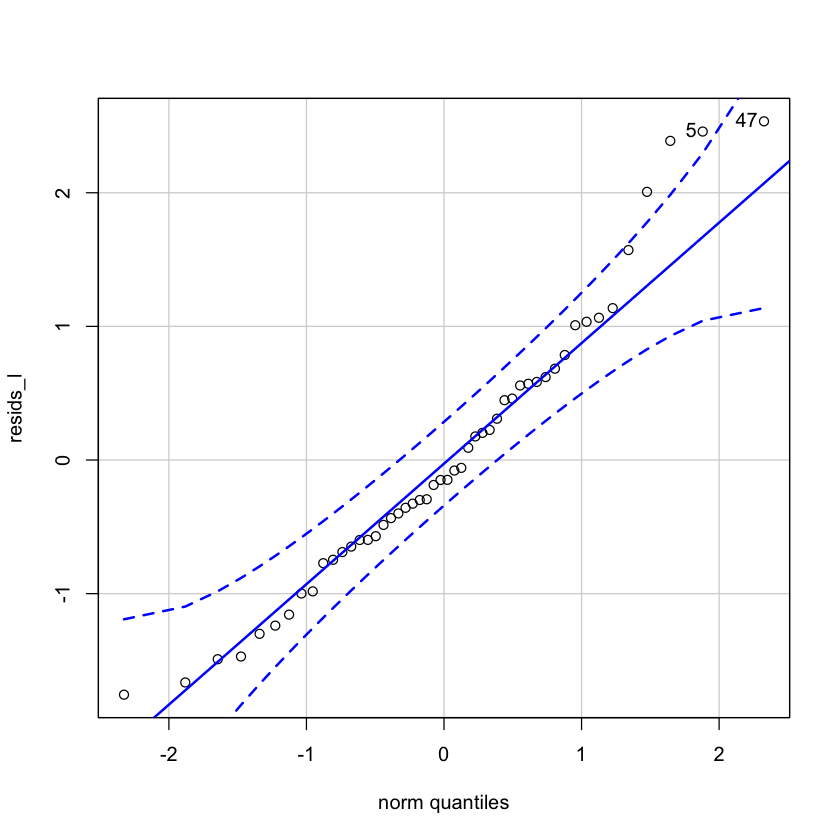

In [275]:
qqPlot(resids_l)